### Relative Foraging Intensity using Inverse Distance Respecting Topograpy using Seal Haulout Data  
input: Olesiuk et al's (2010) and subsequent seal haulout survey data <br>
      Jeffries et al's (2000/2003)  <br>
output: ASC of seal haulout habitat capacity spatial-temporal driver<br>
created: Oct 2019 - Jan 2022<br>
author: G Oldford <br>
based on: gdistance in R by Etten (2014)

Last updated: Jan 8, 2022<br>
Redoing code so it uses the ASC from Ecospace as basemap for transition matrix / interpolation <br>

To do:<br>



### Steps
1) Wrangle haulout data - fix lats / lons, join US and Canada <br>
2) Wrangle - fill gaps between years for each haulout, fix multiple surveys at same haulout in a year <br>
3) Import bathymetry and recode to use as a 'cost' layer <br>
4) Ensure the map projections are correct so the haulout points and cost layer actually overlap <br>
  - 2022 solution is to use unprojected data and tie haulouts to NEMO row / col using spatial join 
5) Main code loop <br>
 - create gdistance 'transition matrix' (Etten 2014) i.e. connectivity matrix w/ edge weights = 0 for non-neighbours
 - create travel 'cost' raster layer for each haulout (represents distance from haulout respecting topog)
 - convert 'cost' to an inverse on-the-water distance grid
 - rescale the grid cell values to sum to 1 for each haulout
 - use the estimated seal abundance at each haulout as measure of relative haulout size to weight the grid cell values
 - sum all haulout rasters using a 'map algebra' approach
 - rescale the grid cell values to 1 in the final raster
 - use the resulting raster as spatial-temp driver of hab in Ecospace
 
 #### to do / issues: 
- 2022 - now simply using rows / cols instead of lats / lons because of several problems with rotated grids
- COMPLETE - add in haulout time series for san juan islands (Jeffries et al)
- problem w/ rotated grids - can't use the Ecospace grid since ASC files do not maintain the georeferencing
- problem w/ NetCDF - the dimensions are in rows / cols only even in original (artifact of rotation)
   - netCDF was output to SHP pts which contained row / col indices as attributes using 'Basemap Converter (Py3).ipynb'
   - for description of rotation issues see beginning of write-up in the Github folder RotatingRastersUsingPython
   - also see the write up in 'Methods Map Prep GO' which I did for CEM FLEM

 
 ## TOC: <a class="anchor" id="top"></a>
* [1. Prep Basemap and gdistance Transition Matrix](#section-1)
* [2. Wrangle Seal Haulout data](#section-2)
    * [2a).](#section-2a)
    * [2b). ](#section-2b)
        * [2b)i.](#section-2bi)
        * [2b)ii.](#section-2bii)
* [3. Interpolation](#section-3)
    
* [4. ](#section-4)
* [Crosschecks and experiments](#section-5)

In [2]:
library(ipdw) # library for inverse path distance weighting
#https://github.com/jsta/ipdw/blob/master/R/pathdistGen.R

library(rgdal)
library(raster)
library(sp)
library(ncdf4)
library(sf) # reads CSV as 'simple features' (spatial)
library(ggplot2) # visualize
library(rnaturalearth)
library(rnaturalearthdata)
library(dplyr)
library(zoom)
library(zoo) #for na.approx
library(tidyverse)

Loading required package: gdistance
Loading required package: raster
Loading required package: sp
Loading required package: igraph

Attaching package: 'igraph'

The following object is masked from 'package:raster':

    union

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Loading required package: Matrix

Attaching package: 'gdistance'

The following object is masked from 'package:igraph':

    normalize

rgdal: version: 1.4-6, (SVN revision 841)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.3, released 2017/11/20
 Path to GDAL shared files: C:/Users/Greig/Documents/R/win-library/3.6/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/Greig/Documents/R/win-library/3.6/rgdal/proj
 Linking to sp version: 1.3-1 
Linking to GEOS 3.6.

## TO DO 
## NOT ALL THE SITES FROM JEFFRIES ARE 
#### interpolation ebtween years not working (NA's in Jeffries data for 1966 - needs a number
#### should but row / col matching stage earlier so don't have to redo ArcMap work

class      : RasterLayer 
dimensions : 299, 132, 39468  (nrow, ncol, ncell)
resolution : 2.274809, 1  (x, y)
extent     : -0.1374046, 300.1374, 0.5, 299.5  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : C:/Users/Greig/Documents/GitHub/NEMO-Salish-Sea-2021/data/bathymetry/bathy_salishsea_20211130_1500m_20210706.nc 
names      : Bathymetry 
zvar       : Bathymetry 


class      : RasterLayer 
dimensions : 299, 132, 39468  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : -0.5, 131.5, -0.5, 298.5  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : Bathymetry 
values     : 1, 10000  (min, max)


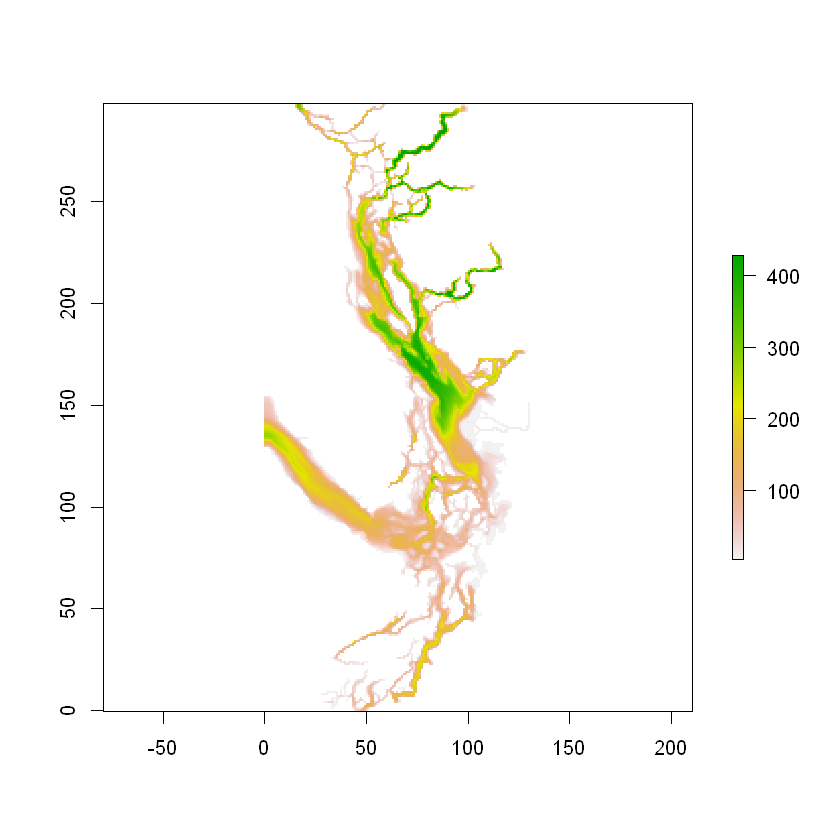

class      : TransitionLayer 
dimensions : 299, 132, 39468  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : -0.5, 131.5, -0.5, 298.5  (xmin, xmax, ymin, ymax)
crs        : NA 
values      : conductance 
matrix class: dsCMatrix 

[1] 299 132   1

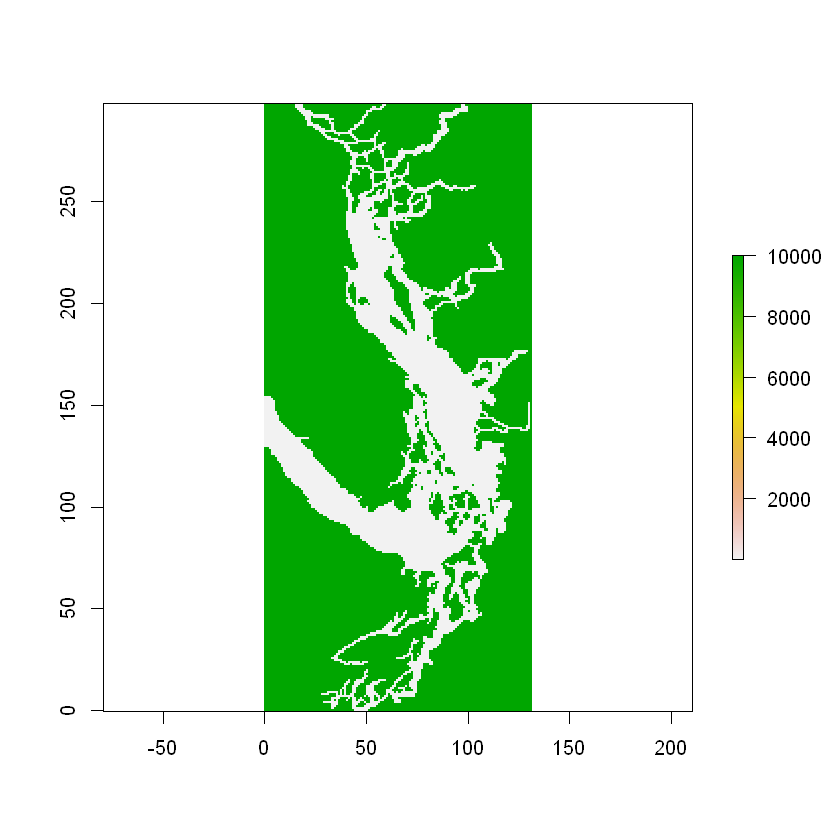

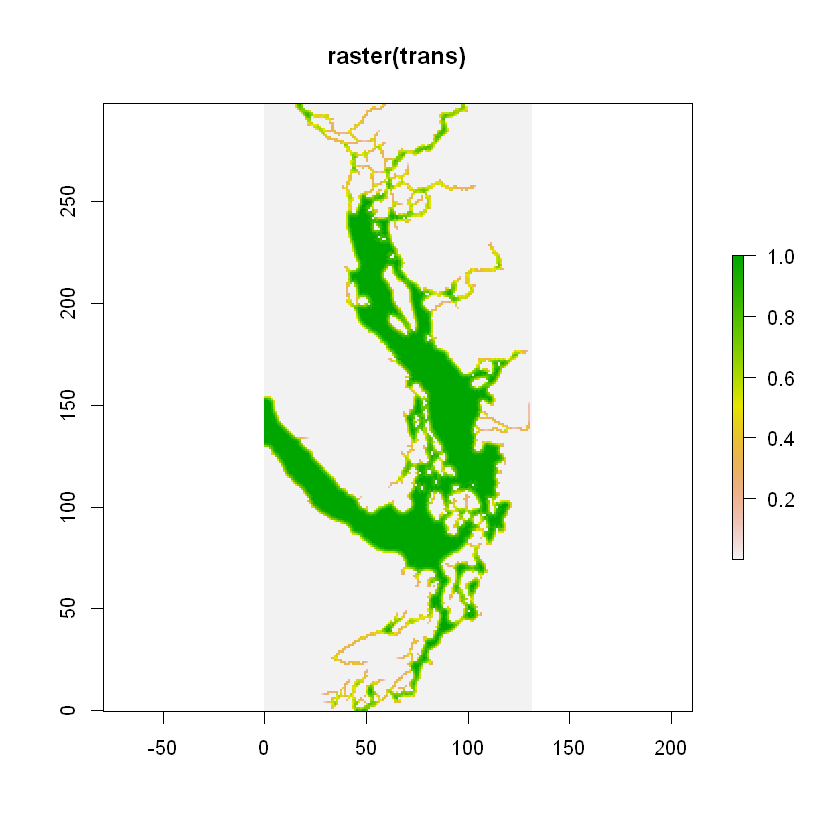

In [110]:
# bathy file for travel cost layer 
ncpath <- "C:/Users/Greig/Documents/GitHub/NEMO-Salish-Sea-2021/data/bathymetry/"
#ncname <- "Bathymetry_1km"
ncname <- "bathy_salishsea_20211130_1500m_20210706"
dname <- "bathymetry"

# read the netcdf file as raster and create a copy to fiddle with
# https://rspatial.org/raster/spatial/8-rastermanip.html
basemap <- raster(ncfname,
                varname = "Bathymetry")

# raster gets the extent wrong and also ignores xmn etc settings within raster()
basemap 
bb <- extent(-0.5, 131.5, -0.5, 298.5)
r <- setExtent(basemap, bb, keepres=FALSE)
plot(r)
basemap <- r

#########################################
### OLD CODE USING NETCDF library ####
## Opens but is rotated b/c no lat lon dimensions (b/c of rotation)
#ncfname <- paste(ncpath, ncname, ".nc", sep="")
#bathync <- nc_open(ncfname)

## looks like no lats lons specified as actual dimensions 
#- this may be to deal w/ problems of rotation or could be a mistake (but it matches S Allen's grid)
#ncvar_get(bathync, varid="x")

# plan is to fake a projection using the rows and cols as lats and lons
# must first give the haulout points a lat and a lon. 
# will simplify and do this in ArcMap (see notes above)
#bathy.array <- ncvar_get(bathync, "Bathymetry")
#fillvalue <- ncatt_get(bathync, "Bathymetry", "_FillValue")
#nc_close(bathync)
#bathy.array[bathy.array == fillvalue$value] <- NA
#plot(raster(bathy.array))

############################################################
#########################################
### BASEMAP TO COST LAYER
x <- basemap

# change the NA values to the raster to 10000 as a high 'cost'
x[is.na(x[])] <- 10000
# change all other values to 1
x[x != 10000] <- 1

x
plot(x)


# Seal Haulout Data Wrangling
<a class="anchor" id="section-2"></a>
[BACK TO TOP](#top)


In [265]:
hl_df <- read.csv("C:/Users/Greig/Sync/6. SSMSP Model/Model Greig/Data/2. Seals/AbundanceLocations_Olesiuketal/MODIFIED/Harbour_Seal_Counts_from_Strait_of_Georgia_Haulout_Locations.csv")
h2_df <- read.csv("C:/Users/Greig/Sync/6. SSMSP Model/Model Greig/Data/2. Seals/Abundance_Jeffries2003/MODIFIED/MatchedCountsWithHaulouts.csv")

# fix issues with some points in wrong hemisphere
hl_df2 <- hl_df %>% mutate(Longitude = 
                               ifelse(Longitude>0, -Longitude, Longitude )
)

h2_df

## External work needed 
### - do spatial join in ArcMap to get the NEMO map rows / cols attached to SHP of haulouts

#hl_pts <- st_read("../AbundanceLocations_Olesiuketal/MODIFIED/Harbour_Seal_Counts_from_Strait_of_Georgia_Haulout_Locations.csv", options=c("X_POSSIBLE_NAMES=Longitude","Y_POSSIBLE_NAMES=Latitude"))

# create spatial pts object in lat / lon (sf R library)
hl_pts <- hl_df2 %>%
  st_as_sf(coords = c("Longitude", "Latitude"), crs = 4326)

h2_pts <- h2_df %>%
  st_as_sf(coords = c("Lon", "Lat"), crs = 4326)

st_write(hl_pts, "tmp_haulouts_Olesiuk_2022_WGS84.shp", delete_layer = TRUE) # overwrites
st_write(h2_pts, "tmp_haulouts_Jeffries_2022_WGS84_1.shp", delete_layer = TRUE) # overwrites

### edit
# 1/ load NEMO points shapefile and tmp_haulouts into ArcMap
#      C:\Users\Greig\Documents\GitHub\Ecosystem-Model-Data-Framework\data\basemap\NEMO_grid_20210208_NoLand.shp
# 2/ spatial join NEMO rows cols to haulouts (use land-omitted version of NEMO points)
# 3/ fix remaining ones that aren't within a 3 km threshold distance to land
# 4/ export haulouts file as CSV (want to lose the georeferencing)

Warning message in abbreviate_shapefile_names(obj):
"Field names abbreviated for ESRI Shapefile driver"

Deleting layer `tmp_haulouts_Olesiuk_2022_WGS84' using driver `ESRI Shapefile'
Writing layer `tmp_haulouts_Olesiuk_2022_WGS84' to data source `tmp_haulouts_Olesiuk_2022_WGS84.shp' using driver `ESRI Shapefile'
Writing 4946 features with 6 fields and geometry type Point.


Warning message in abbreviate(fld_names, minlength = 7):
"abbreviate used with non-ASCII chars"Warning message in abbreviate_shapefile_names(obj):
"Field names abbreviated for ESRI Shapefile driver"

Writing layer `tmp_haulouts_Jeffries_2022_WGS84_1' to data source `tmp_haulouts_Jeffries_2022_WGS84_1.shp' using driver `ESRI Shapefile'
Writing 2774 features with 14 fields and geometry type Point.


In [321]:
############################################################
######################################### 
# import the CSV w/ NEMO rows cols
path_edited_hl_rowscols =  "C:/Users/Greig/Sync/6. SSMSP Model/Model Greig/Data/2. Seals/_MODEL_seal_HabCap/"
hl_pts_Jeffries = read.csv(paste(path_edited_hl_rowscols,"Haulouts_Jeffries_NEMO_rowscols1.csv", sep="")) 
hl_pts_Olesiuk = read.csv(paste(path_edited_hl_rowscols,"Haulouts_Olesiuk_NEMO_rowscols.csv", sep="")) 

hl_pts_Olesiuk$Site.Key <- hl_pts_Olesiuk$Site_Ky
hl_pts_Olesiuk$Date.1 <- hl_pts_Olesiuk$Date_1

hl_pts_Jeffries$site_expanded_est = hl_pts_Jeffries$st_xpn_


hl_pts_Jeffries = hl_pts_Jeffries %>% select(-c(Join_Count,st_xpn_,OID,TARGET_FID,"Ã._RgnID","Regn_Nm",Locatin,Srvy_Cd,Species,Use,wght_GO,X))
hl_pts_Olesiuk = hl_pts_Olesiuk %>% select(-c(Site_Ky,Date_1,OID,Join_Count,TARGET_FID,Lctn_In,Lctn_Vl,Date))

############################################################
######################################### 
#combine (Olesiuk, canada) with (Jeffries et al., 2000, 2003, San Juan islands)

#Note that hl_df is not actually interpreted as a data frame by R, rather a 'list'
# this is why the 'length' method doesn't work unless converted to df

#################################################
####################################
# OLESIUK
# make into 'tibble' - easier to work with in R (tidyverse)
#https://www.datanovia.com/en/lessons/identify-and-remove-duplicate-data-in-r/
hl_df_tib <- as_tibble(hl_pts_Olesiuk)
typeof(hl_df_tib)

# to convert the 'count' from a factor to dbl given a 'list'
hl_df_tib["Count"] <- as.numeric(as.character(unlist(hl_df_tib[["Count"]])))

# get only duplicates
hl_df_grouped <- hl_df_tib %>% group_by(Site.Key, Date.1) %>%
   filter(n()>1) 

# calculate the mean of duplicates
# https://stackoverflow.com/questions/46661461/calculate-mean-by-group-using-dplyr-package
hl_df_dupemean <- hl_df_grouped %>%
   dplyr::summarize(Mean = mean(Count, na.rm=TRUE))

# replace the 'count' for with the mean for certain sites with multiple surveys in a year
# exclude records with duplicate year/site key combo (keeps first record of duplicate)
hl_df_tibDistinct <- hl_df_tib %>% distinct(Date.1, Site.Key, .keep_all = TRUE)

# replaces count for duplicates with the mean value
hl_df_tibFixed <- hl_df_tibDistinct %>% 
  left_join(hl_df_dupemean, by = c("Site.Key","Date.1")) %>% 
  mutate(Count = ifelse(!is.na(Mean),Mean,Count))
  #filter(!is.na(Mean))


#################################################
####################################
# JEFFRIES

# insert a survey value =1 into 1966 (1/3 of pop est for 1972) for each San Juan islands site
# and value equal to last year in survey (1999)
#b/c interpolation requires a 'bookend year' with values
h2_df_fix <- hl_pts_Jeffries[0,]
for(i in unique(hl_pts_Jeffries$ID)){
    h2_df_one = hl_pts_Jeffries %>% filter(ID == i)
    # get earliest record and duplicate that row
    minyeardf = h2_df_one %>% slice_min(yr) # MIN YEAR
    minyeardf_ = minyeardf[1,]
    minyeardf_ = minyeardf_ %>% mutate(yr = 1966) %>% mutate(site_expanded_est = 1)
    h2_df_fix = bind_rows(h2_df_fix, minyeardf_)
}

h2_df_fix2 = bind_rows(h2_df_fix, hl_pts_Jeffries)

# SET 2014 values (matching Olesiuk's last year of stats)
# setting so 2014 vals = 1999 vals (static relative abun at haulouts in San Juan)
h2_df_fixLASTYEAR <- hl_pts_Jeffries[0,]
for(i in unique(hl_pts_Jeffries$ID)){
    h2_df_one = hl_pts_Jeffries %>% filter(ID == i)
    # get earliest record and duplicate that row
    maxyeardf = h2_df_one %>% slice_max(yr) # MAX YEAR
    maxyeardf_ = maxyeardf[1,]
    maxyeardf_ = maxyeardf_ %>% mutate(yr = 2014)
    h2_df_fixLASTYEAR = bind_rows(h2_df_fixLASTYEAR, maxyeardf_)
}

h2_df_fix3 = bind_rows(h2_df_fixLASTYEAR, h2_df_fix2)

#combine hl_df_tibFixed (Olesiuk, canada) with h2_df (Jeffries et al., 2000, 2003, San Juan islands)
h3_df = h2_df_fix3 %>%
  rename(Date.1 = yr) %>%
  select(-c(Count)) %>%
  rename(Count = site_expanded_est) %>%
  mutate(ID = as.factor(ID)) %>%
  rename(Site.Key = ID) 

h2_df_tibFixed = bind_rows(h3_df, hl_df_tibFixed)

[1] "list"

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"`summarise()` regrouping output by 'Site.Key' (override with `.groups` argument)


## FILL DATA GAPS AT HAULOUTS BETWEEN YEARS

`summarise()` regrouping output by 'Date.1' (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
Joining, by = "Site.Key"
Warning message:
"Unknown columns: `LocVal2`, `LocInfo2`, `Lat2`, `Lon2`"

Date.1,Site.Key,yr_tt__,yr_xpn_,lat,lon,depth,col,row,Count,col2,row2
<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1966,363,361,552.33,48.74566,-122.8367,47.8125,105,108,1.000000,NA,NA
1967,363,NA,NA,NA,NA,NA,105,108,1.508695,105,108
1968,363,NA,NA,NA,NA,NA,105,108,2.017390,105,108
1969,363,NA,NA,NA,NA,NA,105,108,2.526085,105,108
1970,363,361,552.33,48.74566,-122.8367,47.8125,105,108,3.034780,NA,NA
1971,363,NA,NA,NA,NA,NA,105,108,3.538125,105,108
1972,363,NA,NA,NA,NA,NA,105,108,4.041470,105,108
1973,363,NA,NA,NA,NA,NA,105,108,4.544815,105,108
1974,363,NA,NA,NA,NA,NA,105,108,5.048159,105,108


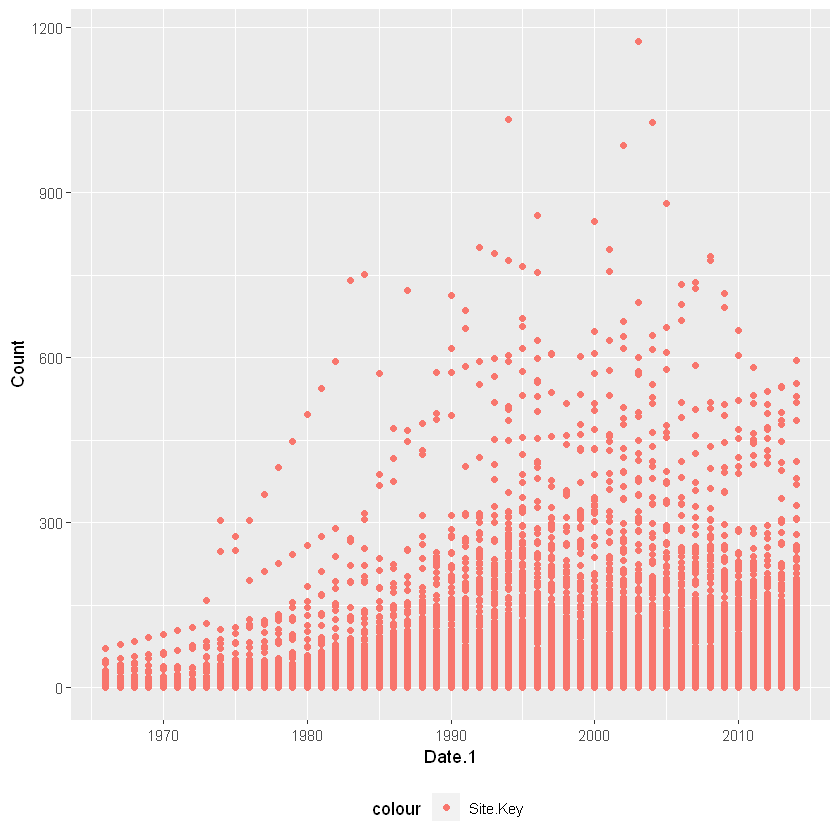

In [324]:
############################################################
######################################### 
#### Interpolate values between survey years for site
#https://stackoverflow.com/questions/43501670/complete-column-with-group-by-and-complete/43501854


all_years <- as_tibble(data.frame("Date.1" = as.integer(c(1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018))))

# insert years / surveys for years in which there were no surveys
hl_df_tibFixExtraYears <- all_years %>% left_join(h2_df_tibFixed, by = c("Date.1")) 


hl_df_expandsurveys <- hl_df_tibFixExtraYears %>% 
    group_by(Date.1,Site.Key) %>% 
    summarise(count_number = n()) %>%
    ungroup() %>%
    complete(Date.1,Site.Key, fill = list(count_number = 1)) %>%
    left_join(hl_df_tibFixExtraYears, by = c("Site.Key","Date.1")) 

# inspect one site - should have empty records for missing years
#hl_df_expandsurveys %>% filter(Site.Key == "393")

SiteSurveyCounts <- hl_df_expandsurveys %>% 
   drop_na(Site.Key) %>%
   group_by(Site.Key)  %>%
   summarise(non_na_count = sum(!is.na(Count)))
# if 1966 is NA set it to zero because interpolation needs a value there. 
   #mutate(x2 = na.approx(Count, Site.Key)) %>%
   #arrange(Site.Key) %>%
   #ungroup()

# interpolate between years for those sites w/ more than one year w/ a survey
hl_fg_tib_Interp <- hl_df_expandsurveys %>% left_join(SiteSurveyCounts, by = c("Site.Key")) %>%
   filter(non_na_count > 1) %>%
   group_by(Site.Key) %>%
   arrange(Site.Key,Date.1) %>%
    # na.approx is interpolator
   mutate(x2 = na.approx(Count,x = Date.1, na.rm=FALSE)) %>%
   rename(Count_old = Count) %>%
   rename(Count = x2) %>%
   ungroup()

# join back the sites /w only one year survey
hl_df_tibAllSurveys <- hl_df_expandsurveys %>% left_join(SiteSurveyCounts, by = c("Site.Key")) %>%
   filter(non_na_count == 1) %>%
   filter(!is.na(Count)) %>%
   bind_rows(hl_fg_tib_Interp) %>%
   filter(!is.na(Count)) 


# NEED TO CONNECT SITES WITH ONLY ONE DATA POINT BACK TO TABLE  
# get list of all unique sites
tab_metadata <- hl_df_tibAllSurveys %>% distinct(Site.Key,row,col,.keep_all = FALSE) %>%
    drop_na(row) %>%
    rename(col2 = col) %>%
    rename(row2 = row)

## this fills in rows and cols into inserted rows
hl_df_filledMetadata1 <- hl_df_tibAllSurveys %>% left_join(tab_metadata) %>%
   filter(is.na(col) & is.na(row)) %>%
   mutate(row = row2) %>%
   mutate(col = col2)

hl_df_filledMetadata <- hl_df_tibAllSurveys %>% 
   filter(!is.na(col) & !is.na(row)) %>% # this was problem GO 2022
   bind_rows(hl_df_filledMetadata1)

#hl_df_filledMetadata %>% group_by(Site.Key, Date.1) %>%
#   filter(n()>1)

# final step
# final table has interpolated counts between survey years
# duplicates surveys of same site in one year - 
# fixing by taking mean value of all duplicates.
# A few have slightly different coordinates
# I did not inspect coordinate issues, kept the first record
hl_df_wrangled <- hl_df_filledMetadata %>% distinct(Date.1, Site.Key, .keep_all = TRUE) %>%
   arrange(Site.Key, Date.1) %>%
   select(-one_of(c("LocVal2","count_number","Mean","non_na_count","Count_old","LocInfo2","Lat2","Lon2")))

hl_df_wrangled


# Libraries
library(ggplot2)

# Plot
hl_df_wrangled %>%
  #filter(Region.Name == "San Juan Islands: Rosario Strait") %>%
  ggplot( aes(x=Date.1, y=Count, group="Site.Key", color="Site.Key")) +
  theme(legend.position="bottom") +
    geom_point()

In [ ]:
#hl_df_wrangled %>% select(-c(OID,TARGET_FID,Join_Count,Srvy_Cd,Date,yr_tt__,wght_GO,Use,Species,Locatin)) %>% filter(Site.Key == "H0013")
#hl_df_tibAllSurveys %>% filter(Site.Key == "393")
#hl_fg_tib_Interp
#hl_df_wrangled %>% filter(Date.1 == "1966")
#hl_df_wrangled %>% filter(Site.Key == "393")
#hl_fg_tib_Interp %>% filter(Site.Key == "H0013")

[1] "haulouts:"


[1] "+proj=aea +lat_1=50 +lat_2=58.5 +lat_0=45 +lon_0=-126 +x_0=1000000 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

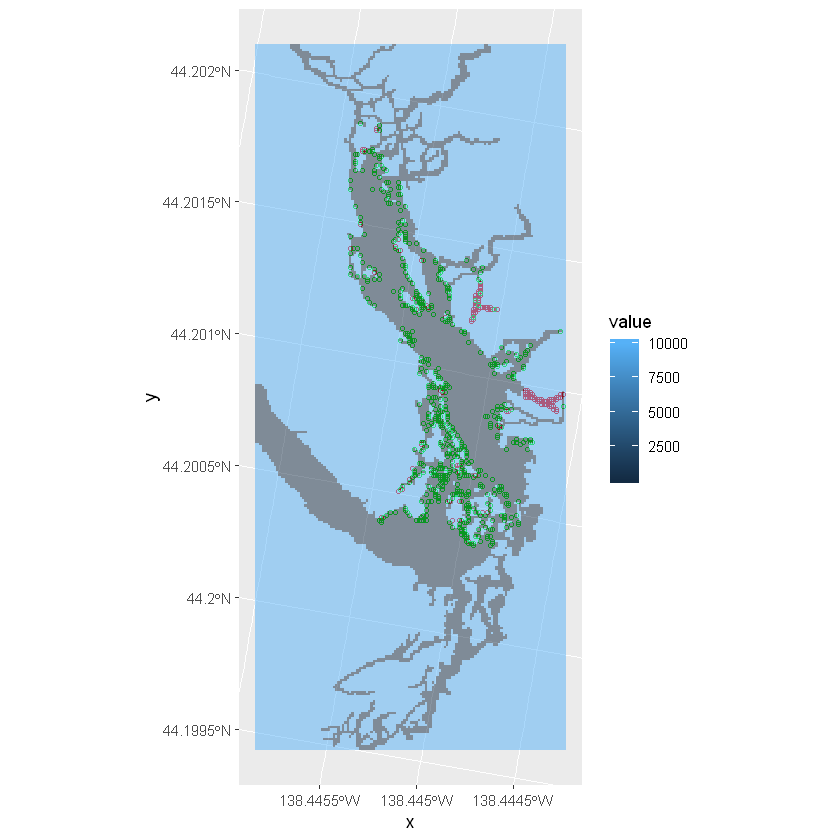

In [326]:
# convert to points using rows / cols as fake geo coords
hl_pts5 <- hl_df_wrangled %>%
  st_as_sf(coords = c("col", "row"))

############################################################
######################################### 
# set fake bc albers projection to line up w/ NEMO
hl_3005 = hl_pts5 %>% st_set_crs(3005) 

crsBathPts <- projection(hl_3005)
print("haulouts:")
crsBathPts

# this appears to be unnecessary but may need it
#x3 = x
#crs(x3) <- CRS('+init=EPSG:3005')

############################################################
######################################### 
# read the 'paths to water' point shapefile, created manually in QGIS
# use points to set cost raster values to '1'
pathsFix_df <- read.csv("C:/Users/Greig/Sync/6. SSMSP Model/Model Greig/Data/2. Seals/_MODEL_seal_HabCap/PathsToWater2022_NEMOrowscols2.csv")
# create spatial pts object in lat / lon (sf R library)
# convert to points using rows / cols as fake geo coords
pathwaterfix_pts <- pathsFix_df %>% st_as_sf(coords = c("col", "row"))
pathwaterfix_3005 = pathwaterfix_pts %>% st_set_crs(3005) 
#pathsFix_sf <- pathsFix_df %>% st_as_sf(coords = c("X", "Y"), crs = CRS('+init=EPSG:3005'))


############################################################
######################################### 
# COERCE transition matrix to raster (for plot)
gplot_data <- function(x, maxpixels = 1000000)  {
  x <- raster::sampleRegular(x, maxpixels, asRaster = TRUE)
  coords <- raster::xyFromCell(x, seq_len(raster::ncell(x)))
  ## Extract values
  dat <- utils::stack(as.data.frame(raster::getValues(x)))
  names(dat) <- c('value', 'variable')

  dat <- dplyr::as.tbl(data.frame(coords, dat))

  if (!is.null(levels(x))) {
    dat <- dplyr::left_join(dat, levels(x)[[1]],
                            by = c("value" = "ID"))
  }
  dat
}

# transform raster to data frame for map display
# (does not work if using gplot_data with x2, the attemped CRS 3005 raster)
ss_ras_df <- gplot_data(x)

ggplot() +
    geom_sf() +
    geom_sf(data = pathwaterfix_3005, size = 1, shape = 1, color=alpha("red",0.9)) +
    geom_sf(data = hl_3005, size = 1, shape = 1, color=alpha("green",0.9)) +
    geom_tile(data = ss_ras_df, aes(x = x, y = y, fill = value), alpha=0.5) #+
    #coord_sf(xlim = c(40, 100), ylim = c(200, 288), expand = FALSE) #coord_sf(xlim = c(100, 140), ylim = c(45, 55), expand = FALSE)


#plot the points
#world <- ne_countries(scale = "medium", returnclass = "sf")
#ggplot(data = world) +
#    geom_sf() +
#    geom_sf(data = hl_pts_3005, size = 1, shape = 1, color=alpha("black",0.9)) + 
#coord_sf(xlim = c(-121, -126), ylim = c(47, 52), expand = FALSE) #coord_sf(xlim = c(100, 140), ylim = c(45, 55), expand = FALSE)


### Check the correction for paths to water where haulouts are on land cells worked

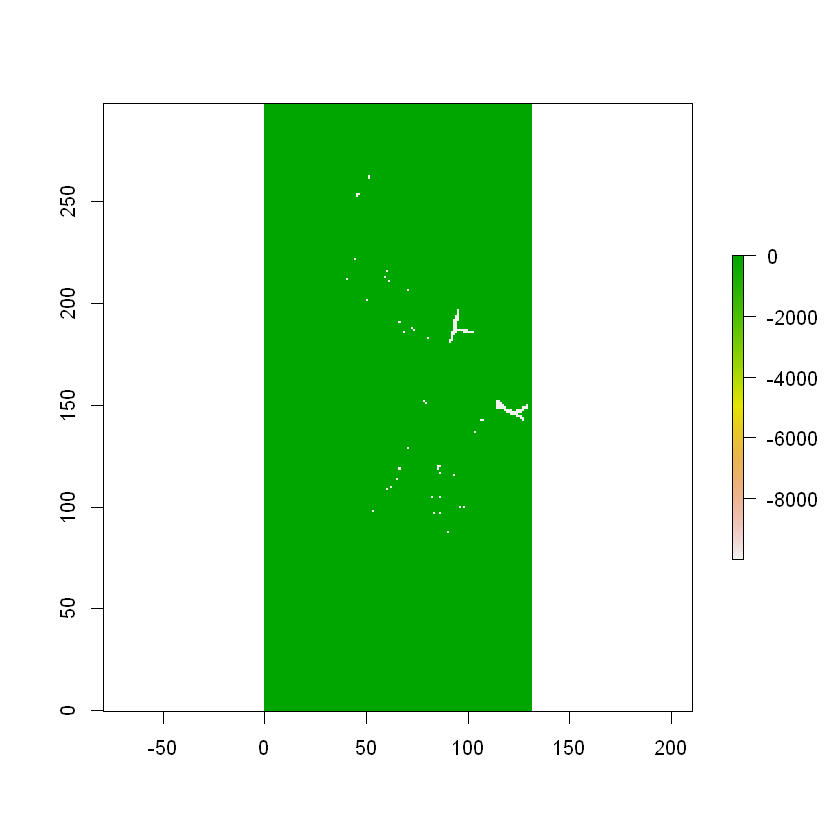

In [328]:
# reproject to BC Albers
#pathsFix_4326 <- pathsFix_df2 %>% st_set_crs(NA) %>% st_set_crs(4326)
#pathsFix_3005 <- pathsFix_4326 %>% st_transform(3005)

# set 'cost' to 1 for all cells with a haulout
# need further edits to ensure seals can make it out of landlocked cells
x2 <- x
ii <- raster::extract(x2, pathwaterfix_3005, cellnumbers=TRUE)[,"cells"]
x2[ii] <- 1

# change all other values to 1
x3 = x2 - x
#x3[x3 != 10000] <- 0
plot(x3)

# Create cost layer and transition matrix

class      : TransitionLayer 
dimensions : 299, 132, 39468  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : -0.5, 131.5, -0.5, 298.5  (xmin, xmax, ymin, ymax)
crs        : NA 
values      : conductance 
matrix class: dsCMatrix 

[1] 299 132   1

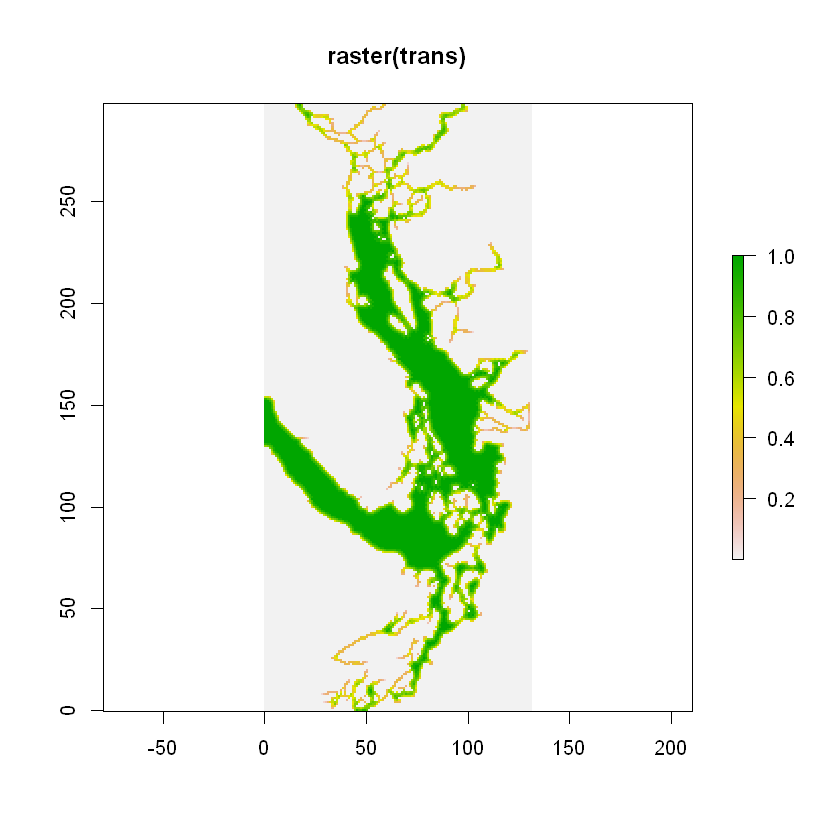

In [329]:

############################################################
#########################################
### COST LAYER TO TRANSITION MATRIX 
## i.e. connectivity matrix

# below drawn from ipdw source code but based on gdistance mostly
# https://github.com/jsta/ipdw/blob/master/R/pathdistGen.R

# (1) calculates the cost to get anywhere from a point on the map
# RANGE = Maximum Foraging Distance (in bathy raster / map units of meters)
#range = 40000 
range = 30 / 1.5 #GO 2022 - the range must now be done as map cells in km and each cell is 1.5 km
costras = x2
ipdw_range <- range / raster::res(costras)[1] # range in map units
# note the cells are not perfectly 500 m, so the ipdw_range is not as expected
  
# create transitionlayer object (gdistance, Etten, 2014)
# stores edge weights defining neighbour connectivity between adjacent cells
# the 1/x instead of x is simply because we want neighbours to be 1 and non-neighbours 0 and
# we are using a costraster map that has high values for land and low values for water instead
# of revers. 
# 1/max(x) or 1 / mean(x) - doesn't matter afaik
# inverting saves space and computation time - most vals are 0 (Etten, 2014)
# by inverting we take advantage of 'sparse' matrices (Etten, 2014)
trans <- gdistance::transition(costras, function(x) 1/mean(x), directions = 16)
# (note - GLO - low conductances = high cost of travel)
# 2022 GO - should 1 / max(x) be 1 / mean(x)?

# NOTES - GLO
# in transition, users define a function f(i,j) to calculate the transition value for each pair of adjacent cells 
# i and j" (quoting from https://cran.r-project.org/web/packages/gdistance/vignettes/gdistance1.pdf)
# also see https://gis.stackexchange.com/questions/280593/understanding-the-values-from-transition-layers-produced-by-the-r-package-gdist
trans
dim(trans) # dim is not consistent in R for some reason (see above) - because it's a special 'object' S4???
plot(raster(trans), main="raster(trans)")


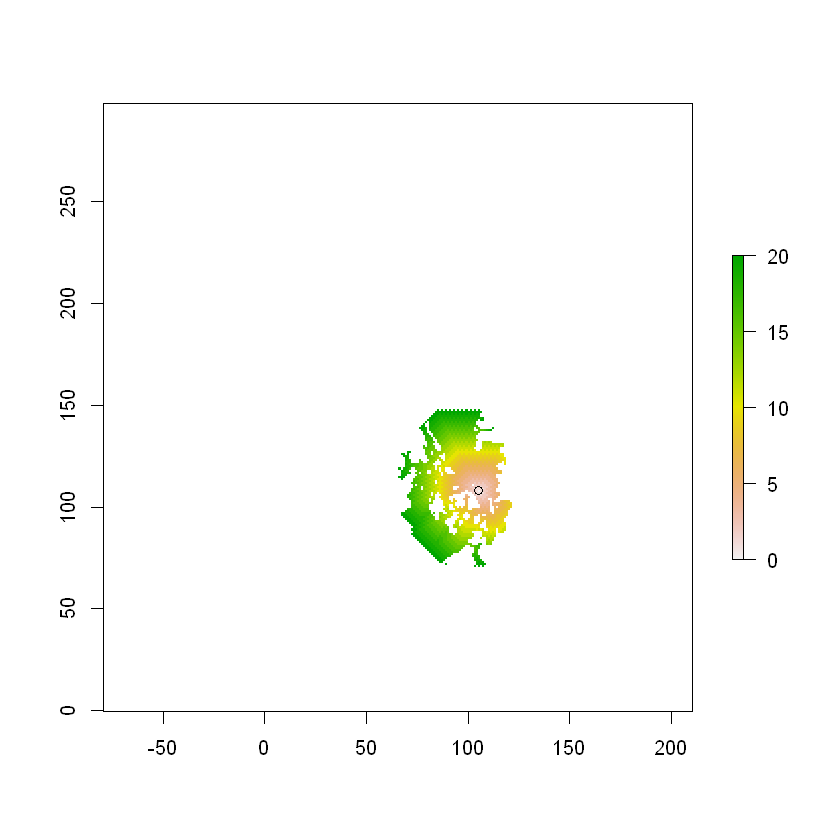

In [330]:
# TEST - create cost surface for a point
#    spdf needs to be sf
coord <- st_coordinates(hl_3005[1,])
costsurf <- gdistance::accCost(trans, coord)

#    added by GLO to set to NA any cells outside the range
costsurf <- calc(costsurf, fun=function(x){ x[x > ipdw_range] <- NA; return(x)} )

raster::writeRaster(costsurf,filename = "tmp_costsurf",format="GTiff", overwrite = TRUE, NAflag = -9999)  
plot(costsurf)
points(st_coordinates(hl_3005[1,]))

# Main Interpolation Loop
### Takes several hours to run
### - Loops over the range of max and min years surveyed

In [346]:
# get unique years (r language = year 'levels')
#y_unique <-unique(format(as.Date(spdf$Date.1, format="%Y-%m-%d"),"%Y"))
hl_3005$Date_1 = hl_3005$Date.1
y_unique <-unique(format(hl_3005$Date_1))

################
# DEBUG
#y_unique = c("1988","1989","1990","1991","1992","1993","1994")
################

# two nested loops (indentation only used for inner)
y <- 1
for (y in 1:length(y_unique)){
    spdf_yr <- filter(hl_3005, Date_1 == y_unique[y])

i <- 1 # haulout index

for(i in seq_len(nrow(spdf_yr))){
    coord <- st_coordinates(spdf_yr[i,])
    costsurf <- gdistance::accCost(trans, coord)

    # (2)
    # set to NA any cells outside the range
    costsurf <- calc(costsurf, fun=function(x){ x[x > ipdw_range] <- NA; return(x)} )

    # (3) make it inverse distance 
    #x_ipdw <- 1/costsurf^2
    #x_ipdw <- calc(costsurf, fun=function(x){ x[x > range] <- NA; return(x)} )
    x_ipdw <- 1/costsurf

    # (4) # fix na's and infinite values
    x_ipdw[is.infinite(x_ipdw[])] <- 1
    x_ipdw[is.na(x_ipdw)] <- 0

    # (6)  Weight each cell's idpw value by the haulout size
    # rescale each cell value out of 1 where 1 = total from all cells
    tot_val = cellStats(x_ipdw,sum)
    #seals = spdf[i,"count"]@data

    pts_count <- spdf_yr %>% as.data.frame 
    # https://stackoverflow.com/questions/34469178/r-convert-factor-to-numeric-and-remove-levels
    seals = as.numeric(as.character(pts_count$Count[i]))
    #seals = spdf[i,"Count"]@data

    var_f = tot_val*seals
    #var_f = tot_val*seals[1,]
    #print("seal count")
    #print(seals)
    #print("tot_val")
    #print(tot_val)
    #print("var_f")
    #print(var_f)
    #print("check 2")

    # each cell = % of total foraging arena (or probability of foraging)
    # weight by cell density at haulout
    x2_ipdw <- x_ipdw / tot_val * seals
    #x2_ipdw <- x_ipdw / tot_val * seals[1,]

    #print("check 3")
    #print(i)
    #print(paste("seals: ", seals))

# (7) Write to disk
    # (best practice is to write so not all rasters stored in RAM)
    raster::writeRaster(x2_ipdw,filename = file.path(tempdir(), paste(y_unique[y],"sealcount", "A1ras", i, ".grd", sep = "")), overwrite = TRUE, NAflag = -99999)
    #print("check 3")

} # end haulout loop

# (8) Open the temp rasters, create rasterstack (one for each haulout)
# get list of temp raster files
raster_flist <- list.files(path = file.path(tempdir()), pattern = paste("sealcount", "A1ras*", sep = ""), full.names = TRUE)
# filter to only get .grd files
raster_flist <- raster_flist[grep(".grd", raster_flist, fixed = TRUE)]

as.numeric(gsub('.*A1ras([0123456789]*)\\.grd$', '\\1', raster_flist)) -> fileNum # get raster by file

raster_flist <- raster_flist[order(fileNum)] # order them
rstack <- raster::stack(raster_flist)
rstack <- raster::reclassify(rstack, cbind(-99999, NA))

# delete temp rasters
file.remove(list.files(path = file.path(tempdir()),
                       pattern = paste("sealcount", "A1ras*", sep = ""), 
                       full.names = TRUE))

##(9) Combine the foraging intensity rasters for each haulout into one raster for all haulouts
# 'add' rasters.
# make sure NA is changed to zero
z <- rstack[[1]]
z[is.na(z[])] <- 0

for (i in 2:nlayers(rstack)){
  each_ras <- rstack[[i]]
  each_ras[is.na(each_ras[])] <- 0
  z <- z + each_ras
}

## (10)
# rescale each cell value in similar fashion as step (6) 
# final result is each cell contains a multiplier (range 0 to 1)
# representing a relative foraging intensity
# can be used to multiple total biomass for SoG to get B per cell
tot_val = cellStats(z, sum)
final_sealrast <- z / tot_val

#raster::writeRaster(final_sealrast,filename = file.path(tempdir(), paste("sealforagingintens",y_unique[y],".Gtiff", sep=""),format="GTiff", overwrite = TRUE, NAflag = -9999)
raster::writeRaster(final_sealrast,filename = paste("sealforagingintens1",y_unique[y],".tiff", sep=""),format="GTiff", overwrite = TRUE, NAflag = -9999)
raster::writeRaster(final_sealrast,filename = paste("sealforagingintens1",y_unique[y],".asc", sep=""),format="ascii", overwrite = TRUE, NAflag = -9999)

#raster::writeRaster(final_sealrast,filename = file.path(tempdir(), paste(y_unique[y],"sealcount", "A1ras", i, ".grd", sep = "")), overwrite = TRUE, NAflag = -99999)
#raster::writeRaster(final_sealrast,filename = paste("TMPsealforagingintens",y_unique[y],".tiff", sep=""),format="GTiff", overwrite = TRUE, NAflag = -9999)

print(paste("Finished year: ", y))
}# end year loop

[1] "Finished year:  1"
[1] "Finished year:  2"
[1] "Finished year:  3"
[1] "Finished year:  4"
[1] "Finished year:  5"
[1] "Finished year:  6"
[1] "Finished year:  7"
[1] "Finished year:  8"
[1] "Finished year:  9"
[1] "Finished year:  10"
[1] "Finished year:  11"
[1] "Finished year:  12"
[1] "Finished year:  13"
[1] "Finished year:  14"
[1] "Finished year:  15"
[1] "Finished year:  16"
[1] "Finished year:  17"
[1] "Finished year:  18"
[1] "Finished year:  19"
[1] "Finished year:  20"
[1] "Finished year:  21"
[1] "Finished year:  22"
[1] "Finished year:  23"
[1] "Finished year:  24"
[1] "Finished year:  25"
[1] "Finished year:  26"
[1] "Finished year:  27"
[1] "Finished year:  28"
[1] "Finished year:  29"
[1] "Finished year:  30"
[1] "Finished year:  31"
[1] "Finished year:  32"
[1] "Finished year:  33"
[1] "Finished year:  34"
[1] "Finished year:  35"
[1] "Finished year:  36"
[1] "Finished year:  37"
[1] "Finished year:  38"
[1] "Finished year:  39"
[1] "Finished year:  40"
[1] "Fini

In [152]:
tempdir()

[1] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i"

In [342]:
raster::writeRaster(final_sealrast,filename = paste("sealforagingintens1",y_unique[y],".asc", sep=""),format="ascii", overwrite = TRUE, NAflag = -9999)
#raster::writ

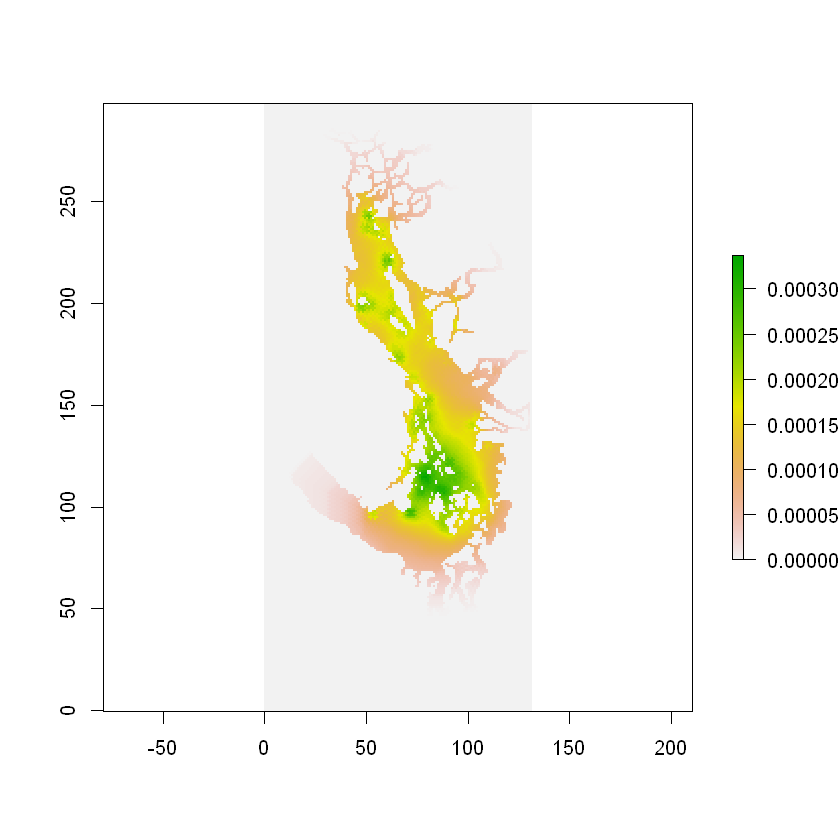

In [347]:
plot(final_sealrast)

In [158]:
raster_flist

[1] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras1.grd"  
  [2] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras2.grd"  
  [3] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras3.grd"  
  [4] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras4.grd"  
  [5] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras5.grd"  
  [6] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras6.grd"  
  [7] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras7.grd"  
  [8] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras8.grd"  
  [9] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras9.grd"  
 [10] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras10.grd" 
 [11] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras11.grd" 
 [12] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras12.grd" 
 [13] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras13.grd" 
 [14] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras14.grd" 
 [15] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras15.grd" 
 [16] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras16.grd" 
 [17] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras17.grd" 
 [18] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras18.grd" 
 [19] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras19.grd" 
 [20] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras20.grd" 
 [21] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras21.grd" 
 [22] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras22.grd" 
 [23] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras23.grd" 
 [24] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras24.grd" 
 [25] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras25.grd" 
 [26] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras26.grd" 
 [27] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras27.grd" 
 [28] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras28.grd" 
 [29] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras29.grd" 
 [30] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras30.grd" 
 [31] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras31.grd" 
 [32] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras32.grd" 
 [33] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras33.grd" 
 [34] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras34.grd" 
 [35] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras35.grd" 
 [36] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras36.grd" 
 [37] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras37.grd" 
 [38] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras38.grd" 
 [39] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras39.grd" 
 [40] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras40.grd" 
 [41] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras41.grd" 
 [42] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras42.grd" 
 [43] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras43.grd" 
 [44] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras44.grd" 
 [45] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras45.grd" 
 [46] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras46.grd" 
 [47] "C:\\Users\\Greig\\AppData\\Local\\Temp\\RtmpI1qc4i/1991sealcountA1ras47.grd" 
 [48] "

In [340]:
# alter to write to ASC with proper header etc. 


def saveASCFile(filename, data):
    #Greig's bounds clipping from "Basemap Converter (Py3).ipynb"
    #I don't know why this works but it does...
    trimmedData = []
    i =  bottomleft_row_ewe 
    while i < upperleft_row_ewe:
        trimmedData.append(data[i,upperleft_col_ewe:])
        i += 1
    trimmedData.reverse()

    np.savetxt(filename,trimmedData,fmt='%0.5f', delimiter=" ", comments='',header=ASCheader)


#array offsets for clipping EwE grid out of NEMO grid
#Calculated by Greig in "Basemap Converter (Py3).ipynb"
upperleft_row_ewe = 253
upperleft_col_ewe = 39
bottomleft_row_ewe = 102
bottomleft_col_ewe = 39
ASCheader = "ncols        93\nnrows        151 \nxllcorner    -123.80739\nyllcorner    48.29471 \ncellsize     0.013497347 \nNODATA_value  0.0"


ERROR: Error in parse(text = x, srcfile = src): <text>:4:5: unexpected symbol
3: 
4: def saveASCFile
       ^


In [339]:
final_sealrast

class      : RasterLayer 
dimensions : 299, 132, 39468  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : -0.5, 131.5, -0.5, 298.5  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : layer 
values     : 0, 0.0003467352  (min, max)
